## [예제 데이터]

> 기업 CEO 성별, 은행 대출 이자율, 기업형태(personal, partner, corporation), 매출액(백만불), 기업설립연수(년)

> 1053 기업(확률 층화추출 - 층화변수 CEO 성별 남녀) 표본조사

In [3]:
import pandas as pd
bank=pd.read_csv('http://wolfpack.hnu.ac.kr/Stat_Notes/example_data/bank.csv')
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1053 entries, 0 to 1052
Data columns (total 5 columns):
gender      1053 non-null object
rate        1053 non-null float64
biz_type    1053 non-null object
sales       1053 non-null int64
found_yr    1053 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 41.2+ KB


## [연봉데이터 분석하기] - 모평균 검정
> 시나리오 : 작년 은행이 기업에 준 대출 이자율 평균이 1.3%였다.

> 작년에 비해 올해 기업 대출 이자율이 높았나?

## 그래프 요약

> 대출이자, 히스토그램, 상자수염그림

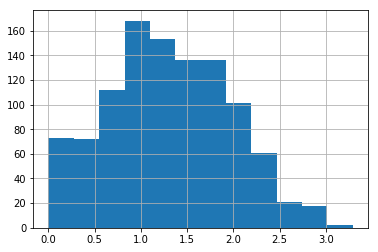

In [3]:
bank['rate'].hist(bins=12)

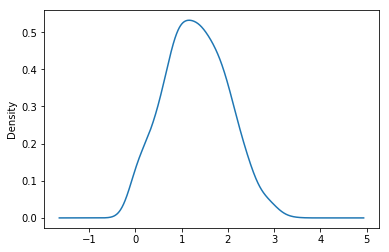

In [0]:
bank['rate'].plot.kde(bw_method=0.3) #probability density function kernel-density estimate

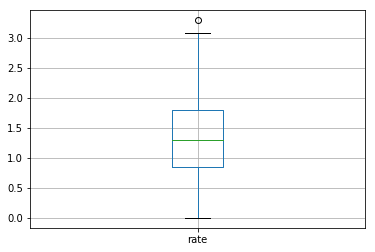

In [0]:
bank.boxplot(column=['rate'])

## 숫자요약

In [5]:
print('Mean=',bank['rate'].mean(),'SD=',bank['rate'].std())

Mean= 1.3033618233618243 SD= 0.6690390213696831


In [6]:
Q1=bank['rate'].quantile(.25)
md=bank['rate'].quantile(.5)
Q3=bank['rate'].quantile(.75)
IQR=Q3-Q1
print('1st Quartile',Q1,'Median',md,'3rd Quartile',Q3,'사분위범위',IQR)

1st Quartile 0.85 Median 1.29 3rd Quartile 1.79 사분위범위 0.9400000000000001


In [7]:
outliers_dn=bank[bank['rate']<(Q1-1.5*IQR)]
print(outliers_dn)

Empty DataFrame
Columns: [gender, rate, biz_type, sales, found_yr]
Index: []


> 하위 구간 이상치 없음

In [8]:
outliers_up=bank[bank['rate']>(Q3+1.5*IQR)]
print(outliers_up)

    gender  rate     biz_type  sales  found_yr
439   Male  3.29  corporation    918         8


> 상위 구간 이상치 1개 출력, 439번째 기업

## 이상치 삭제

> 상자수염 - 이상치 진단에 의해

> (삭제 이유) 표본 표준편차 크기를 크게하여 신뢰구간의 폭을 넓힌다.

>> 이자율이 0인 기업 데이터 삭제 - 이자율 0인 기업은 특혜에 해당되어 삭제함

In [36]:
bank_clean=bank[(bank.rate<Q3+1.5*IQR) & (bank.rate>0)]
bank_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1021 entries, 0 to 1052
Data columns (total 5 columns):
gender      1021 non-null object
rate        1021 non-null float64
biz_type    1021 non-null object
sales       1021 non-null int64
found_yr    1021 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 47.9+ KB


## 치우침 진단

> (필요 이유) 표본 크기가 작은 경우 모집단의 분포가 치우침이 큰 경우 - 데이터가 충분히 큰 경우에는 문제 없음

> (진단방법)=정규성 검정 Anderson Darling 검정통계량 / Shapiro Wilks 방법

> 귀무가설 : 표본 데이터는 정규분포를 따른다.

> 대립가설 : 표본데이터는 정규분포를 따르지 않는다.

In [37]:
from scipy.stats import anderson
anderson(bank_clean['rate'])

AndersonResult(statistic=1.8622590573418165, critical_values=array([0.574, 0.653, 0.784, 0.914, 1.088]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [38]:
from scipy.stats import shapiro
stat, p = shapiro(bank_clean['rate'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=0.990, p=0.000


> (치우침 해결방법) (우로 치우침) 제곱근 > 로그변환 > -1/X (좌로 치우침) X^2 > X^3

> http://wolfpack.hnu.ac.kr/Stat_Notes/elem_stat/Stat_methods/정규변환.pdf

> Tukey Power 변환 : X^lambda/(1-lambda)

> Box Cox 변환 : (X^lambda-1)/(lambda)


In [55]:
import numpy as np
stat, p = shapiro(np.sqrt(bank_clean['rate'])) #sqrt transformation
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=0.983, p=0.000


In [56]:
stat, p = shapiro(np.log(bank_clean['rate'])) #log transformation
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=0.871, p=0.000


In [52]:
xt,lbm=stats.boxcox(bank_clean['rate']) #box-cox transformation / xt transformed data
print('lambda=%.2f'% lbm)

lambda=0.75


In [53]:
stat, p = shapiro(xt)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=0.994, p=0.001


Text(0.5, 1.0, 'Probplot after Box-Cox transformation')

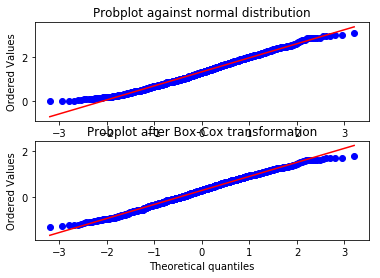

In [54]:
from scipy import stats
import matplotlib.pyplot as plt
fig = plt.figure()
ax1 = fig.add_subplot(211)
prob = stats.probplot(bank_clean['rate'], dist=stats.norm,plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')
ax2 = fig.add_subplot(212)
xt, _ = stats.boxcox(bank_clean['rate'])
prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Box-Cox transformation')

## 모평균 가설검정

> 귀무가설 : 모집단 평균은 mu0이다. mu=mu0 

>> (예제) 작년 평균 대출 이자율 1.3%에 비해 올해 증가하였나? mu0=1.3

> 대립가설 : 모집단 평균은 mu0보다 크다. mu!=mu0 (양측가설)

>> mu>mu0, mu<mu0 (단측가설)

>> 이자율 증가하였다. mu>1.3 (상한 단측 검정)

> 검정통계량 : (xbar - mu0)/(sd/sqrt(n)) ~ t(자유도=n-1), xbar=표본평균, sd=표본표준편차, n=표본크기

In [63]:
from scipy import stats
stats.ttest_1samp(bank_clean['rate'],1.3) #양측검정을 위한 p-값 제안

Ttest_1sampResult(statistic=2.058705187983459, pvalue=0.039776000926327375)

In [71]:
ts,p=stats.ttest_1samp(bank_clean['rate'],1.3)
two_side=0;alpha=0.05
if two_side==0:
  p=p/2
if p<0.05:
  print('reject H0 ts=%.3f p-value=%.4f'%(ts,p))
else:
  print('Accept H0 ts=%.3f p-value=%.4f'%(ts,p))

reject H0 ts=2.059 p-value=0.0199


In [70]:
from scipy.stats import t
import numpy as np
mu0=1.28; alpha=0.05; two_side=1
xbar=bank_clean['rate'].mean()
sd=bank_clean['rate'].std()
n=bank_clean['rate'].shape[0]
ts=(xbar-mu0)/(sd/np.sqrt(n))
if two_side==1:
  p=(1-t.cdf(ts,n-1))*2
else:
  p=1-t.cdf(ts,n-1)
if p<0.05:
  print('pop. mean=%.3f test statistics=%.3f pvalues=%.4f (Reject H0)' % (xbar,ts, p))
else:
  print('pop. mean=%.3f test statistics=%.3f pvalues=%.4f (Accept H0)' % (xbar,ts, p))

pop. mean=1.341 test statistics=3.063 pvalues=0.0022 (Reject H0)


## (1-alpha)*100% 신뢰구간 구하기

> xbar +- t(자유도=n-1,(1-alpha))*sd/sqrt(n), xbar=표본평균, sd=표본표준편차, n=표본크기

> 함수 t.ppf(1-alpha,df=n-1)

In [73]:
from scipy.stats import t
import numpy as np
alpha=0.05
xbar=bank_clean['rate'].mean()
sd=bank_clean['rate'].std()
n=bank_clean['rate'].shape[0]
lb=xbar-t.ppf(1-alpha,df=n-1)*sd/np.sqrt(n)
ub=xbar+t.ppf(1-alpha,df=n-1)*sd/np.sqrt(n)
print('모평균 추정치=%.3f, 모평균 %2d%% 신뢰구간 : 하한=%.3f, 상한=%.3f' % (xbar,(1-alpha)*100,lb,ub))

모평균 추정치=1.341, 모평균 95% 신뢰구간 : 하한=1.308, 상한=1.374


# [모비율 검정]